<a target="_blank" href="https://colab.research.google.com/github/google-research/big_vision/blob/main/big_vision/configs/proj/image_text/SigLIP2_demo.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# General information

Example colab for SigLIP 2 models described in the [SigLIP 2 paper](https://arxiv.org/abs/2502.14786).

**These models are not official Google products and were trained and released for research purposes.**

If you find these model(s) useful for your research, consider citing

```
@article{tschannen2025siglip,
  title={SigLIP 2: Multilingual Vision-Language Encoders with Improved Semantic Understanding, Localization, and Dense Features},
  author={Tschannen, Michael and Gritsenko, Alexey and Wang, Xiao and Naeem, Muhammad Ferjad and Alabdulmohsin, Ibrahim and Parthasarathy, Nikhil and Evans, Talfan and Beyer, Lucas and Xia, Ye and Mustafa, Basil and H\'enaff, Olivier and Harmsen, Jeremiah and Steiner, Andreas and Zhai, Xiaohua},
  year={2025},
  journal={arXiv preprint arXiv:2502.14786}
}
```

If you use our released models in your products, we appreciate any direct feedback. Please contact tschannen@google.com to get in touch.

This Colab was forked from the previous version
[SigLIP_demo.ipynb](https://colab.research.google.com/github/google-research/big_vision/blob/main/big_vision/configs/proj/image_text/SigLIP_demo.ipynb)

In [ ]:
#@markdown # Environment setup
#@markdown Tested on GPU, TPU, and CPU with ViT-B/16 @256px.
import os
if 'NVIDIA_PRODUCT_NAME' in os.environ:
  !nvidia-smi
import jax
jax.devices()


# Get latest version of big_vision codebase.
!git clone --quiet --branch=main --depth=1 https://github.com/google-research/big_vision
!cd big_vision && git pull --rebase --quiet
!pip -q install -r big_vision/big_vision/requirements.txt
# Gives us ~2x faster gsutil cp to get the model checkpoints.
!pip3 -q install --no-cache-dir -U crcmod

%cd big_vision


import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import jax
import jax.numpy as jnp
import ml_collections

from google.colab.output import _publish as publish

Tue Mar  4 18:37:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
#@markdown Image credit:

#@markdown - The apple and apple + iPod images are from OpenAI.
#@markdown - Cows on beach were created by Chitwan Saharia using the Imagen model and shared with permission.
#@markdown - [Cold drink on hot day](https://unsplash.com/fr/photos/hQHm2D1fH70).
#@markdown - [Hot drink on cold day](https://www.rawpixel.com/image/3282934).
#@markdown - The remaining pictures are personal photos taken by the SigLIP1 authors.

!wget -q https://cdn.openai.com/multimodal-neurons/assets/apple/apple-ipod.jpg
!wget -q https://cdn.openai.com/multimodal-neurons/assets/apple/apple-blank.jpg
!wget -q 'https://images.unsplash.com/photo-1566467021888-b03548769dd1?ixlib=rb-4.0.3&q=85&fm=jpg&crop=entropy&cs=srgb&dl=svetlana-gumerova-hQHm2D1fH70-unsplash.jpg&w=640' -O cold_drink.jpg
!wget -q 'https://images.rawpixel.com/image_1300/czNmcy1wcml2YXRlL3Jhd3BpeGVsX2ltYWdlcy93ZWJzaXRlX2NvbnRlbnQvbHIvdXB3azU4ODU5NzY1LXdpa2ltZWRpYS1pbWFnZS1rb3diMmhkeC5qcGc.jpg' -O hot_drink.jpg
!wget -q https://storage.googleapis.com/big_vision/siglip/authors.jpg
!wget -q https://storage.googleapis.com/big_vision/siglip/siglip.jpg
!wget -q https://storage.googleapis.com/big_vision/siglip/caffeine.jpg
!wget -q https://storage.googleapis.com/big_vision/siglip/robosign.jpg
!wget -q https://storage.googleapis.com/big_vision/siglip/fried_fish.jpeg
!wget -q 'https://pbs.twimg.com/media/FTyEyxyXsAAyKPc?format=jpg&name=small' -O cow_beach.jpg
!wget -q 'https://storage.googleapis.com/big_vision/siglip/cow_beach2.jpg' -O cow_beach2.jpg
!wget -q 'https://pbs.twimg.com/media/Frb6NIEXwAA8-fI?format=jpg&name=medium' -O mountain_view.jpg
!wget -q https://storage.googleapis.com/big_vision/siglip2/siglip2_screenshot.jpg


# Choose and load model, perform inference

In [ ]:
# Pick your hero: (WHEN CHANGING THIS, RERUN IMAGE/TEXT EMBEDDING CELLS)
# Give this cell 1-3mins.

# VARIANT, RES = 'B/32', 256
# VARIANT, RES = 'B/16', 224
# VARIANT, RES = 'B/16', 256
# VARIANT, RES = 'B/16', 384
# VARIANT, RES = 'B/16', 512
# VARIANT, RES, N_PATCHES = 'B/16', 'naflex', 256
# VARIANT, RES = 'L/16', 256
# VARIANT, RES = 'L/16', 384
# VARIANT, RES = 'L/16', 512
VARIANT, RES = 'So400m/16', 256
# VARIANT, RES = 'So400m/16', 384
# VARIANT, RES = 'So400m/16', 512
# VARIANT, RES, N_PATCHES = 'So400m/16', 'naflex', 256
# VARIANT, RES = 'So400m/14', 224
# VARIANT, RES = 'So400m/14', 384
# VARIANT, RES = 'g-opt/16', 256
# VARIANT, RES = 'g-opt/16', 384

CKPT = f'siglip2_{VARIANT.lower().replace("/", "")}_{RES}.npz'
TXTVARIANT, PATCH_SIZE = VARIANT.split('/')
EMBDIM = {'B': 768, 'L': 1024, 'So400m': 1152, 'g-opt': 1536}[TXTVARIANT]
# Note: The g-opt vision encoder is paired with a So400m text encoder
TXTVARIANT = 'So400m' if TXTVARIANT == 'g-opt' else TXTVARIANT
PATCH_SIZE = int(PATCH_SIZE)
VOCAB = 256_000
SEQLEN = 64

# It is significantly faster to first copy the checkpoint (30s vs 8m30 for B and 1m vs ??? for L)
!test -f /tmp/{CKPT} || gsutil cp gs://big_vision/siglip2/{CKPT} /tmp/

import big_vision.models.proj.image_text.two_towers as model_mod

model_cfg = ml_collections.ConfigDict(dict(
    image_model='vit',
    image=dict(
        pool_type='map',
        scan=True,
        variant=VARIANT,
    ),
    text_model='proj.image_text.text_transformer',
    text=dict(
        scan=True,
        variant=TXTVARIANT,
        vocab_size=256_000,
    ),
    out_dim=[None, EMBDIM],
    bias_init=-10,  # without this arg, no "b" param is added
))
if RES == 'naflex':
  model_cfg.image_model = 'proj.image_text.naflex_vit'
  model_cfg.image = dict(
      pool_type='map',
      nposemb=16,
      posemb='learn_2d',
      variant='B'
  )

model = model_mod.Model(**model_cfg)

# Using `init_params` is slower but will lead to `load` below performing sanity-checks.
# init_params = jax.jit(model.init, backend="cpu")(jax.random.PRNGKey(42), jnp.zeros([1, RES, RES, 3], jnp.float32), jnp.zeros([1, SEQLEN], jnp.int32))['params']
init_params = None  # Faster but bypasses loading sanity-checks.

params = model_mod.load(init_params, f'/tmp/{CKPT}', model_cfg)

Copying gs://big_vision/siglip2/siglip2_so400m16_256.npz...
\ [1 files][  4.2 GiB/  4.2 GiB]   86.7 MiB/s                                   
Operation completed over 1 objects/4.2 GiB.                                      


In [ ]:
# # inspect params:
# from clu import parameter_overview
# print(parameter_overview.get_parameter_overview(params))

In [ ]:
#@title Load and embed images

import big_vision.pp.builder as pp_builder
import big_vision.pp.ops_general
import big_vision.pp.ops_image
import big_vision.pp.ops_text
import big_vision.pp.proj.image_text.ops_naflex
import big_vision.pp.proj.paligemma.ops
import PIL

images = [PIL.Image.open(fname) for fname in [
    'apple-ipod.jpg',
    'apple-blank.jpg',
    'cold_drink.jpg',
    'hot_drink.jpg',
    'caffeine.jpg',
    'siglip.jpg',
    'authors.jpg',
    'robosign.jpg',
    'cow_beach.jpg',
    'cow_beach2.jpg',
    'mountain_view.jpg',
]]

get_pp_naflex = lambda n_patches, patch_size: pp_builder.get_preprocess_fn('|'.join((
    'value_range(-1, 1)',
    f'resize_to_sequence({patch_size}, {n_patches}, outkey="image")',
    f'patchify({patch_size}, key="image")',
    'flatten(["image"])',
    f'pad_to_shape(key="image/patches", shape=({n_patches}, None))',
    f'pad_to_shape(key="image/type", shape=({n_patches},))',
    f'pad_to_shape(key="image/yidx", shape=({n_patches},))',
    f'pad_to_shape(key="image/xidx", shape=({n_patches},))',
    'tuplify(["image/patches", "image/type", "image/yidx", "image/xidx"], "image")',
)))

if RES == 'naflex':
  # See section "NaFlex" below for a comparison of this preprocessing with
  # resize to square.
  pp_img = get_pp_naflex(N_PATCHES, PATCH_SIZE)
  imgs = [pp_img(dict(image=np.array(image)))['image'] for image in images]
  imgs = tuple(np.stack(_) for _ in zip(*imgs))
  print('imgs', tuple(x.shape for x in imgs))
else:
  pp_img = pp_builder.get_preprocess_fn(f'resize({RES})|value_range(-1, 1)')
  imgs = np.array([pp_img({'image': np.array(image)})['image'] for image in images])
  print('imgs', imgs.shape)

zimg, _, out = model.apply({'params': params}, imgs, None)

print('zimg', zimg.shape)

imgs (11, 256, 256, 3)
zimg (11, 1152)


In [ ]:
#@title Tokenize and embed texts

# texts with translations into random languages
texts_dict = {
    'an apple': 'tufaha',  # Swahili
    'a picture of an apple': 'ένα μήλο',  # Greek (Modern)
    'an ipod': 'айпод',  # Russian
    'an apple with a note saying "ipod"': 'apple na nóta ag rá "ipod"',  # Irish
    'a cold drink on a hot day': 'en kold drink på en varm dag', # Danish
    'a hot drink on a cold day': 'een hete drank op een koude dag', # Dutch
    'a photo of a cold drink on a hot day': '炎热天气里一杯冷饮的照片', # Chinese
    'a photo of a hot drink on a cold day': 'foto cangkir panas dina dinten tiis',  # Sundanese
    #
    'a photo of two guys in need of caffeine': 'एक तस्वीर जिसमें दो लोगों को कैफीन की ज़रूरत है',  # Hindi
    'a photo of two guys in need of water': 'o imagine a doi tipi care au nevoie de apă',  # Romanian
    'a photo of the SigLIP authors': 'foto para penulis SigLIP',  # Indonesian
    'a photo of a rock band': 'ロックバンドの写真', # Japanese
    'a photo of researchers at Google Brain': 'foto av forskare på Google Brain', # Swedish
    'a photo of researchers at OpenAI': 'OpenAI:n tutkijoiden kuva',  # Finnish
    #
    'cow': 'sapi',  # Indonesian
    'a cow in a tuxedo': 'une vache en smoking',  # French
    'a cow on the beach': 'פרה על החוף', # Hebrew
    #
    # Croatian:
    'a picture of a laptop with the lockscreen on, a cup of cappucino, salt and pepper grinders. The view through the window reveals lake Zürich and the Alps in the background of the city.': "slika prijenosnog računala sa zaključanim zaslonom, šalica cappuccina, mlinci za sol i papar. Pogled kroz prozor otkriva jezero Zürich i Alpe u pozadini grada.",
}

# ‼️ NOTE: SigLIP 2 models work best with lowercase texts
pp_txt = pp_builder.get_preprocess_fn(f'lower(key="text")|tok(length={SEQLEN}, model="gemma", bos="no", eos="sticky", key="text")')


def embed_texts(texts):
  txts = np.array([pp_txt({'text': text})['text'] for text in texts])
  _, ztxt, out = model.apply({'params': params}, None, txts)
  return txts, ztxt, dict(t=out['t'], b=out['b'])


txts, ztxt, out = embed_texts(texts_dict)
print(txts.shape, ztxt.shape)

(18, 64) (18, 1152)


In [ ]:
# This is how to get all probabilities:
print(f"Learned temperature {out['t'].item():.1f}, learned bias: {out['b'].item():.1f}")
probs = jax.nn.sigmoid(zimg @ ztxt.T * out['t'] + out['b'])
print(f"{probs[0][0]:.1%} that image 0 is '{list(texts_dict)[0]}'")
print(f"{probs[0][1]:.1%} that image 0 is '{list(texts_dict)[1]}'")

Learned temperature 109.9, learned bias: -15.9
21.8% that image 0 is 'an apple'
33.6% that image 0 is 'a picture of an apple'


In [ ]:
# @title Pretty demo (code)
from IPython.display import Javascript, HTML

DEMO_IMG_SIZE = 96

import base64
import io

def bv2rgb(bv_img):
  return (bv_img * 127.5 + 127.5).astype(np.uint8)

def img2html(img):
  with io.BytesIO() as buf:
    img.save(buf, format="JPEG")
    enc_img = buf.getvalue()
  img_data = base64.b64encode(np.ascontiguousarray(enc_img)).decode('ascii')
  return f'<img src="data:image/jpeg;base64,{img_data}"/>'


def make_table(zimg, ztxt, images, texts, out):
  # The default learnable bias is a little conservative. Play around with it!
  t, b = out['t'].item(), out['b'].item()
  tempered_logits = zimg @ ztxt.T * t
  probs = 1 / (1 + np.exp(-tempered_logits - b))
  publish.javascript(f"var logits = {tempered_logits.tolist()};")

  def color(p):
    return mpl.colors.rgb2hex(mpl.cm.Greens(p / 2)) if p >= 0.01 else "transparent"

  publish.javascript(f"var cmap = {[color(x) for x in np.linspace(0, 1, 50)]};")
  def cell(x, iimg, itxt):
    return f"<td id=td_{iimg}_{itxt} style=background-color:{color(x)} class=pct><pre id=p_{iimg}_{itxt}>{x * 100:>4.0f}%</pre>"

  html = f'''
  <p>
  <label for=b>Bias value:</label>
  <input id=b type=range min=-20 max=0 step=0.1 name=b value={b} style=vertical-align:middle>
  <output id=value></output>
  </p>
  '''

  html += "<table>\n"
  html += "<tr>"
  html += "".join([f"<td style='width:{DEMO_IMG_SIZE}px;line-height:0'>" + img2html(img.resize([DEMO_IMG_SIZE, DEMO_IMG_SIZE])) for img in images])
  html += "<td>"
  for itxt, txt in enumerate(texts):
    html += f"<tr>" + "".join([cell(probs[iimg, itxt], iimg, itxt) for iimg in range(len(images))]) + f"<td class=txt>{txt}"

  publish.css(r"""
  table {
    border-collapse: collapse;
  }

  tr {
    border: 1px transparent;
  }

  tr:nth-child(odd) {
    background-color: #F5F5F5;
  }

  tr:hover {
    background-color: lightyellow;
    border: 1px solid black;
  }

  td.pct {
    text-align: center;
  }
  """)
  publish.html(html)

  # JS code to compute and write all probs from the logits.
  display(Javascript('''
  function update(b) {
    for(var iimg = 0; iimg < logits.length; iimg++) {
      for(var itxt = 0; itxt < logits[iimg].length; itxt++) {
        const el = document.getElementById(`p_${iimg}_${itxt}`);
        const p = Math.round(100 / (1 + Math.exp(-logits[iimg][itxt] - b)));
        const pad = p < 10.0 ? '  ' : p < 100.0 ? ' ' : ''
        el.innerHTML = pad + (p).toFixed(0) + '%';

        const td = document.getElementById(`td_${iimg}_${itxt}`);
        const c = cmap[Math.round(p / 100 * (cmap.length - 1))];
        td.style.backgroundColor = c;
      }
    }
  }
  '''))

  # JS code to connect the bias value slider
  display(Javascript('''
  const value = document.querySelector("#value");
  const input = document.querySelector("#b");
  value.textContent = input.value;
  input.addEventListener("input", (event) => {
    value.textContent = event.target.value;
    update(event.target.value);
  });
  '''))

  # Make the cell output as large as the table to avoid annoying scrollbars.
  display(Javascript(f'update({b})'))
  display(Javascript('google.colab.output.resizeIframeToContent()'))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


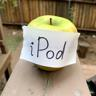
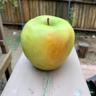
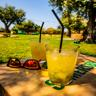
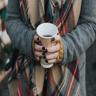
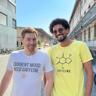
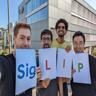
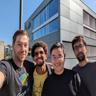
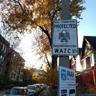
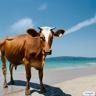
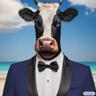
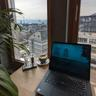

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
make_table(zimg, ztxt, images, texts_dict, out)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


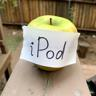
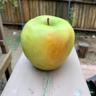
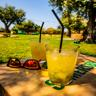
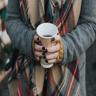
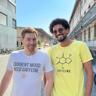
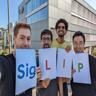
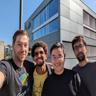
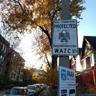
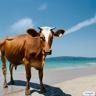
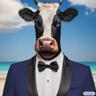
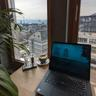

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# The same checkpoint also works well across a wide array of langauges.
# Note that we adapt the bias a bit to correct for preponderance of English.
make_table(zimg, embed_texts(texts_dict.values())[1], images, texts_dict.values(), {**out, 'b': np.array(-10.0)})

# Naflex

Example to compare the aspect-preserving NaFlex preprocessing with resizing to fixed-resolution square.

In [ ]:
# Example document image with height >> width.
img = PIL.Image.open('siglip2_screenshot.jpg')
print(img.size)
# img  # show image in original resolution

(1000, 2853)


In [ ]:
# Split the image into 1024 naflex patches of size 16.
pp_naflex = get_pp_naflex(1024, 16)

# These are encoded as the actual patches, input mask, y and x indices.
patches, input_mask, yidx, xidx = map(np.array, pp_naflex(dict(image=np.array(img)))['image'])
print(patches.shape, input_mask.shape, yidx.shape, xidx.shape)

(1024, 768) (1024,) (1024,) (1024,)


In [ ]:
patches, yidx, xidx = map(lambda x: x[:input_mask.sum()], (patches, yidx, xidx))  # remove padding
cols = xidx.max() + 1
cols

19

Text(0.5, 1.0, 'yidx')

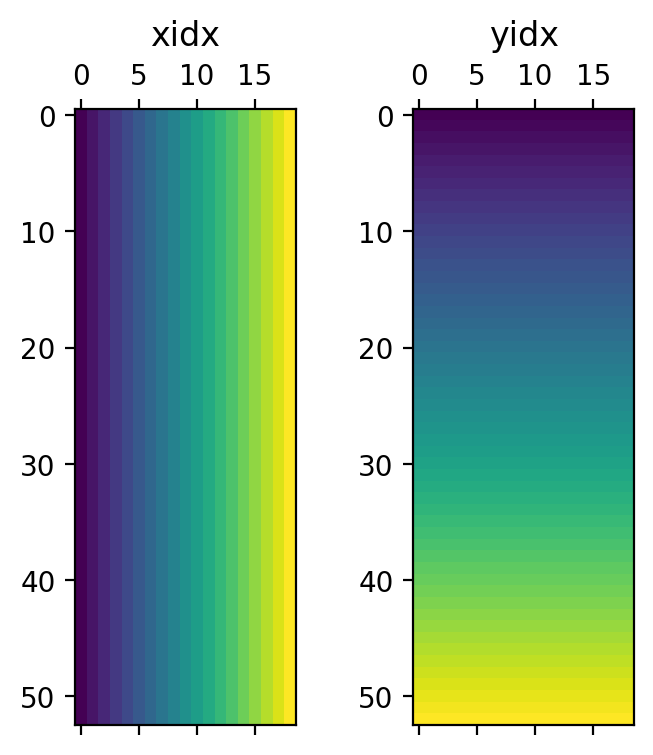

In [ ]:
# Visualizing the indices
_, axs = plt.subplots(1, 2, figsize=(4, 4))
axs[0].matshow(xidx.reshape([-1, cols]))
axs[0].set_title('xidx')
axs[1].matshow(yidx.reshape([-1, cols]))
axs[1].set_title('yidx')


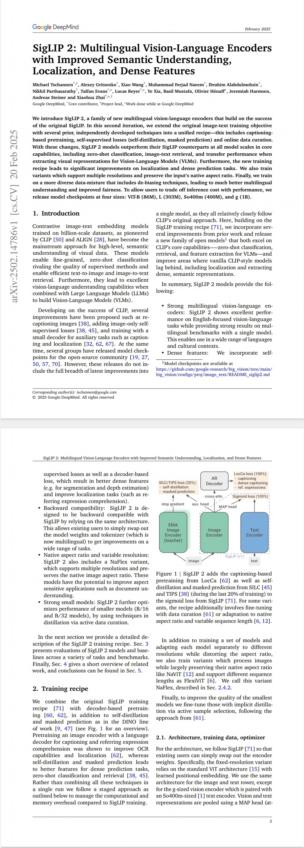

In [ ]:
import einops
patches_rearranged = einops.rearrange(patches.reshape([-1, cols, PATCH_SIZE, PATCH_SIZE, 3]), 'r c y x z -> (r y) (c x) z')
img_naflex = PIL.Image.fromarray((patches_rearranged * 127.5 + 127.5).astype('uint8'))
# (work around broken saved outputs)
HTML(img2html(img_naflex))
# Note how 1024 patches represent the text somewhat readable thanks to NaFlex...


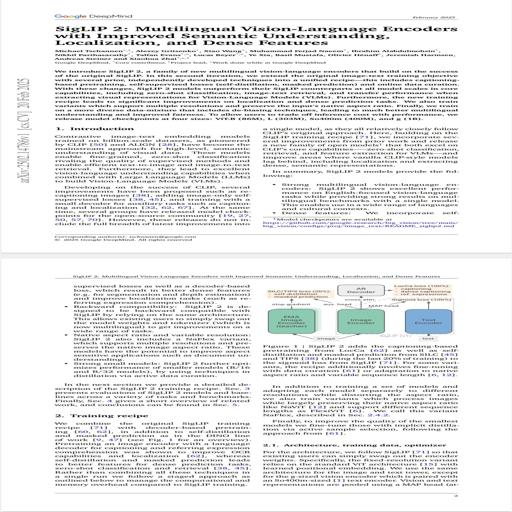

In [ ]:
# ...compared to the resize to square with the same number of patches (and pixels).
img_resize_to_square = img.resize([32 * 16, 32 * 16])
HTML(img2html(img_resize_to_square))